# Federated Learning with BraTS 2021 Dataset
This notebook implements a federated learning framework for brain tumor segmentation using the BraTS 2021 dataset.

In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [2]:
images_path = 'Data/BraTS2021'
IMG_SIZE = 128  # Resize images to 128x128
VOLUME_SLICES = 50  # Number of slices per patient
VOLUME_START_AT = 22  # Start slicing from this index
REDUCE_PATIENTS = False  # Option to reduce the number of patients per hospital
PATIENT_LIMIT = 10  # Number of patients per hospital if REDUCE_PATIENTS is Tru

# Load the dataset file paths
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

In [3]:
# Split dataset among hospitals (nodes)
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}

In [4]:
# Define Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(images_path, os.path.basename(i), os.path.basename(i))
            flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
            seg = nib.load(f'{case_path}_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3  # Adjust class values
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return X / np.max(X), Y

In [5]:
# Distribute dataset into train, validation, and test sets
hospitals_data = {}
for hospital, files in nodes.items():
    np.random.shuffle(files)
    train_split = int(0.7 * len(files))
    val_split = int(0.85 * len(files))
    hospitals_data[hospital] = {
        "train": DataGenerator(files[:150]),
        "val": DataGenerator(files[150:180]),
        "test": DataGenerator(files[180:200])
    }


# Print dataset shapes for each hospital
    print(f"{hospital}: Train={len(hospitals_data[hospital]['train'])}, Val={len(hospitals_data[hospital]['val'])}, Test={len(hospitals_data[hospital]['test'])}")

Hospital_1: Train=150, Val=30, Test=20
Hospital_2: Train=150, Val=30, Test=20
Hospital_3: Train=150, Val=30, Test=20


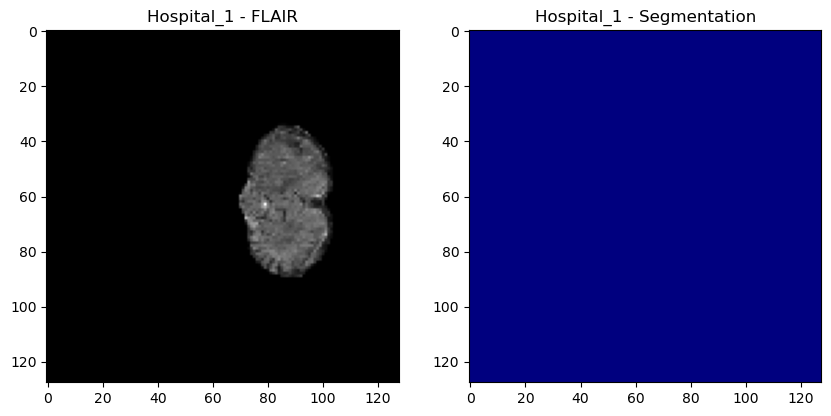

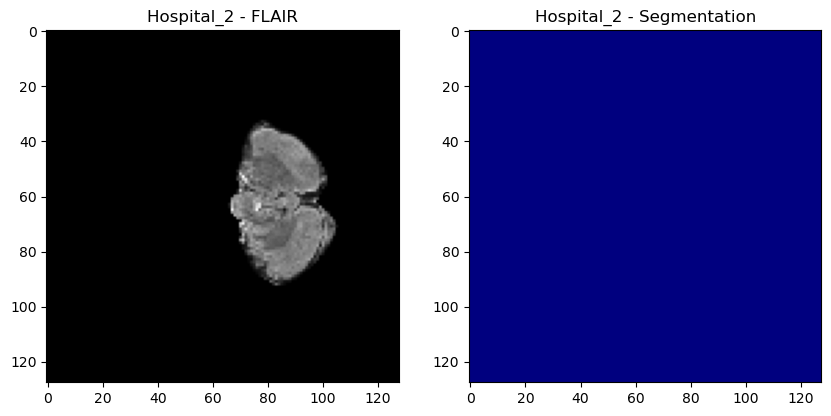

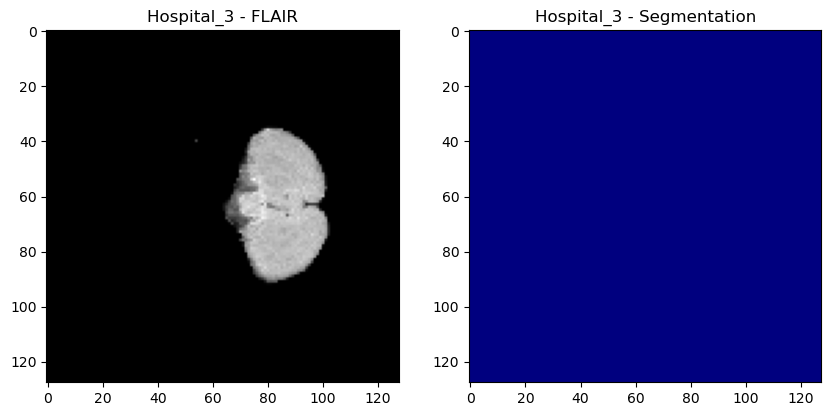

In [6]:
# Visualize Some Slices from Each Hospital
for hospital, data in hospitals_data.items():
    X_sample, y_sample = data['train'].__getitem__(0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_sample[0, :, :, 0], cmap='gray')
    ax[0].set_title(f"{hospital} - FLAIR")
    ax[1].imshow(np.argmax(y_sample[0], axis=-1), cmap='jet')
    ax[1].set_title(f"{hospital} - Segmentation")
    plt.show()

In [7]:
## Cell 5: Define UNet model with proper upsampling
def create_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 2)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(4, (4, 4), strides=(4, 4), activation='softmax', padding='same')(x)  # Proper upsampling
    return keras.Model(inputs, x)

In [8]:
# Initialize models for each hospital
local_models = {}
for hospital in hospitals_data.keys():
    local_models[hospital] = create_unet_model()

In [9]:
num_rounds = 1
global_model = create_unet_model()

def federated_averaging(weight_list):
    avg_weights = []
    for weights in zip(*weight_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights


In [11]:
for round_num in range(num_rounds):
    local_weights = []
    
    for hospital in hospitals_data.keys():
        print(f"Training {hospital}...")

        # Free memory before training each hospital
        tf.keras.backend.clear_session()

        # Create a fresh model to avoid memory leak
        local_model = create_unet_model()
        local_model.set_weights(global_model.get_weights())
        
        # Compile and train
        local_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        local_model.fit(hospitals_data[hospital]['train'], epochs=1, validation_data=hospitals_data[hospital]['val'])
        
        # Save trained weights
        local_weights.append(local_model.get_weights())

    new_global_weights = federated_averaging(local_weights)
    global_model.set_weights(new_global_weights)


Training Hospital_1...
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9749 - loss: 0.4943

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [WinError 8] Not enough memory resources are available to process this command
Traceback (most recent call last):

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_16960\2993538711.py", line 17, in __getitem__
    X, y = self.__data_generation(Batch_ids)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\binwa\AppData\Local\Temp\ipykernel_16960\2993538711.py", line 31, in __data_generation
    flair = nib.load(f'{case_path}_flair.nii').get_fdata()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\dataobj_images.py", line 373, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 457, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 424, in _get_scaled
    scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_inter)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\arrayproxy.py", line 394, in _get_unscaled
    return array_from_file(
           ^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\nibabel\volumeutils.py", line 450, in array_from_file
    return np.memmap(infile, in_dtype, mode=mode, shape=shape, order=order, offset=offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\binwa\anaconda3\Lib\site-packages\numpy\core\memmap.py", line 268, in __new__
    mm = mmap.mmap(fid.fileno(), bytes, access=acc, offset=start)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OSError: [WinError 8] Not enough memory resources are available to process this command


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_10819]

In [ ]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate the global model on each hospital's test set
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


In [ ]:
# Ensure the global model is compiled before evaluation
global_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Evaluate on each hospital's test set
global_results = {}
for hospital, data in hospitals_data.items():
    loss, acc = global_model.evaluate(data["test"])
    global_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Global Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")


In [ ]:
# Ensure local models are compiled before evaluation
local_results = {}
for hospital, model in local_models.items():
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    loss, acc = model.evaluate(hospitals_data[hospital]['test'])
    local_results[hospital] = {"Loss": loss, "Accuracy": acc}
    print(f"Local Model - {hospital}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")

# Compare local vs. global accuracy
for hospital in hospitals_data.keys():
    print(f"{hospital} - Local Model Accuracy: {local_results[hospital]['Accuracy']:.4f}, Global Model Accuracy: {global_results[hospital]['Accuracy']:.4f}")


In [ ]:
# Extract accuracy values
hospitals = list(hospitals_data.keys())
local_accuracies = [local_results[h]["Accuracy"] for h in hospitals]
global_accuracies = [global_results[h]["Accuracy"] for h in hospitals]

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(hospitals, local_accuracies, alpha=0.6, label="Local Models")
plt.bar(hospitals, global_accuracies, alpha=0.6, label="Global Model")
plt.xlabel("Hospitals")
plt.ylabel("Accuracy")
plt.title("Local vs Global Model Accuracy")
plt.legend()
plt.show()


In [ ]:
for hospital, data in hospitals_data.items():
    y_true_list, y_pred_list = [], []
    
    for i in range(len(data["test"])):
        X_batch, y_batch = data["test"].__getitem__(i)
        y_true_list.append(np.argmax(y_batch, axis=-1).flatten())
        y_pred_list.append(np.argmax(global_model.predict(X_batch), axis=-1).flatten())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel(), pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{hospital} (AUC = {roc_auc:.2f})")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters for reaction-diffusion model
def reaction_diffusion_simulation(size=128, time_steps=50, diffusion_rate=0.2, growth_rate=0.05):
    tumor = np.zeros((size, size))
    tumor[size//2, size//2] = 1  # Initial tumor seed
    
    for _ in range(time_steps):
        diffusion = gaussian_filter(tumor, sigma=diffusion_rate)
        tumor = diffusion + growth_rate * tumor * (1 - tumor)  # Growth term
        tumor = np.clip(tumor, 0, 1)
    
    return tumor

# Simulate and visualize
tumor_sim = reaction_diffusion_simulation()
plt.imshow(tumor_sim, cmap='hot')
plt.title("Simulated Tumor Growth (Reaction-Diffusion Model)")
plt.colorbar()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Create artificial tumor growth sequences
def generate_tumor_growth_series(num_samples=100, time_steps=10, size=128):
    series = []
    for _ in range(num_samples):
        tumor_series = []
        for t in range(time_steps):
            tumor_series.append(reaction_diffusion_simulation(size=size, time_steps=t))
        series.append(tumor_series)
    return np.array(series)

# Generate dataset
tumor_growth_series = generate_tumor_growth_series()
X_train = tumor_growth_series[:, :-1]  # All time steps except last
y_train = tumor_growth_series[:, -1]   # Last time step prediction target

print(f"Generated Tumor Growth Data: {X_train.shape} -> {y_train.shape}")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten

# Define LSTM model
def build_lstm_model(input_shape=(9, 128, 128, 1)):
    model = Sequential([
        TimeDistributed(Flatten(), input_shape=input_shape),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(128 * 128, activation='sigmoid'),
        layers.Reshape((128, 128))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2)


In [19]:
import gym
from gym import spaces

class TumorTreatmentEnv(gym.Env):
    def __init__(self):
        super(TumorTreatmentEnv, self).__init__()
        self.state = reaction_diffusion_simulation()
        self.action_space = spaces.Discrete(4)  # 0: No Treatment, 1: Radiotherapy, 2: Chemo, 3: Surgery
        self.observation_space = spaces.Box(low=0, high=1, shape=self.state.shape, dtype=np.float32)

    def step(self, action):
        # Apply treatment effects
        if action == 1:  # Radiotherapy
            self.state *= 0.9  # Shrink tumor slightly
        elif action == 2:  # Chemotherapy
            self.state *= 0.85  # Higher tumor shrinkage
        elif action == 3:  # Surgery
            self.state[:64, :64] = 0  # Remove tumor region (mock surgery)
        
        reward = -np.sum(self.state)  # Lower tumor = better reward
        done = np.sum(self.state) < 0.1  # Termination condition

        return self.state, reward, done, {}

    def reset(self):
        self.state = reaction_diffusion_simulation()
        return self.state

env = TumorTreatmentEnv()


In [ ]:
import gymnasium as gym
import stable_baselines3 as sb3
import shimmy

print("Shimmy Version:", shimmy.__version__)
print("Gymnasium Version:", gym.__version__)
print("Stable-Baselines3 Version:", sb3.__version__)


In [ ]:
import stable_baselines3 as sb3

model = sb3.PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(y_train[0], cmap='hot')
axes[0].set_title("Real Tumor Growth")
axes[1].imshow(lstm_model.predict(X_train[0:1])[0], cmap='hot')
axes[1].set_title("Predicted Tumor Growth")
plt.show()


In [ ]:
treatment_results = []
for action in range(4):
    state = env.reset()
    for _ in range(10):
        state, _, _, _ = env.step(action)
    treatment_results.append(state)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
titles = ["No Treatment", "Radiotherapy", "Chemotherapy", "Surgery"]
for i, result in enumerate(treatment_results):
    axes[i].imshow(result, cmap='hot')
    axes[i].set_title(titles[i])
plt.show()
